### Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
import string
import matplotlib.pyplot as plt
import time

from indoNLP.preprocessing import replace_word_elongation, replace_slang, remove_stopwords

import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Cleaning Data dan Preprocessing

In [ ]:
def cleanDataframe(df):
    print('Missing Values:', df.isnull().sum())
    print('Duplicates:', df.duplicated().sum())

    df_cleaned = df.dropna(subset='teks')
    df_cleaned = df_cleaned.drop_duplicates(keep='first')

    print('Missing values after cleaning:', df_cleaned.isnull().sum())
    print('Duplicates after cleaning:', df_cleaned.duplicated().sum())
    return df_cleaned

def cleaningText(text):
    # Membersihkan tanda tanda sisa medsos
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus Mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus Hashtag
    text = re.sub(r'RT[\s]', '', text)  # menghapus RT
    text = re.sub(r"http\S+", '', text)  # menghapus link

    # Pembersihan Karakter
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))) # Mengganti tanda baca dengan spasi (alih-alih menghapus)
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = text.replace('\n', ' ') # Mengganti garis baru dengan spasi

    # Normalisasi
    text = text.strip(' ') # Menghapus karakter spasi dari kiri dan kanan teks
    text = text.lower()  # mengubah semua karakter dalam teks menjadi huruf kecil
    text = re.sub(r'(.)\1+', r'\1\1', text) # Menghapus huruf berlebih di belakang
    text = replace_word_elongation(text) # Menghapus text elongation (library indoNLP)
    text = replace_slang(text) # Menghapus slangwords dari kamus IndoNLP
    #text = remove_stopwords(text)  # menghapus kata yang tidak penting
    text = re.sub(r'\s+', ' ', text) # Mengganti multiple spasi dengan satu spasi
    return text



In [ ]:
# Load file
english_df = pd.read_csv("../data/translated_augmented.csv")

# Cek isi
print(english_df.head())

     label                                         final_text  \
0  sadness                            i didnt feel humiliated   
1  sadness  i can go from feeling so hopeless to so damned...   
2    anger   im grabbing a minute to post i feel greedy wrong   
3     love  i am ever feeling nostalgic about the fireplac...   
4    anger                               i am feeling grouchy   

                                                teks  
0                      aku tidak merasa dipermalukan  
1  saya bisa berubah dari tadinya perasaan putus ...  
2  gua meluangkan waktu sebentar untuk memposting...  
3  saya pernah merasa nostalgia tentang perapian ...  
4                            aku sedang merasa kesal  


In [ ]:
english_df = cleanDataframe(english_df)

Missing Values: label            0
final_text    2993
teks             0
dtype: int64
Duplicates: 0
Missing values after cleaning: label            0
final_text    2993
teks             0
dtype: int64
Duplicates after cleaning: 0


In [ ]:
english_df['teks'] = english_df['teks'].apply(cleaningText)
english_df['teks']

,teks
0,aku tidak merasa dipermalukan
1,saya bisa berubah dari tadinya perasaan putus ...
2,gua meluangkan waktu sebentar untuk memposting...
3,saya pernah merasa nostalgia tentang perapian ...
4,aku sedang merasa kesal
...,...
22936,aku tidak tahu apakah aku merasa khawatir atau...
22937,aku perlu tidur tapi aku enggan untuk melupaka...
22938,aku pergi berbelanja dengan seorang teman hari...
22939,aku merasa tak berdaya dan aku tak bisa berbua...


In [ ]:
# Cek persebaran dari label
print(english_df['label'].value_counts())

label
joy         6740
sadness     5793
love        2998
anger       2997
fear        2994
surprise    1419
Name: count, dtype: int64


### Persiapan Dataset untuk Finetuning

In [ ]:
# Encode label ke angka
label_encoder = LabelEncoder()
english_df['label_encoded'] = label_encoder.fit_transform(english_df['label'])

# Splitting data menjadi 70:15:15
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    english_df['teks'], english_df['label_encoded'],
    test_size=0.3, stratify=english_df['label_encoded'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

In [ ]:
# Tokenisasi
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors='tf')

# Mengubah Label ke bentuk yang bisa diterima tensor
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Pembuatan Dataset Tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

### Pemodelan

In [ ]:
# Load Pretrain Model
model = TFAutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(label_encoder.classes_)
)

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Pelatihan Model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3
1004/1004 [==============================] - 335s 287ms/step - loss: 0.7250 - accuracy: 0.7469 - val_loss: 0.5345 - val_accuracy: 0.8062
Epoch 2/3
1004/1004 [==============================] - 287s 286ms/step - loss: 0.4371 - accuracy: 0.8466 - val_loss: 0.5391 - val_accuracy: 0.8140
Epoch 3/3
1004/1004 [==============================] - 285s 284ms/step - loss: 0.3184 - accuracy: 0.8852 - val_loss: 0.5775 - val_accuracy: 0.8126


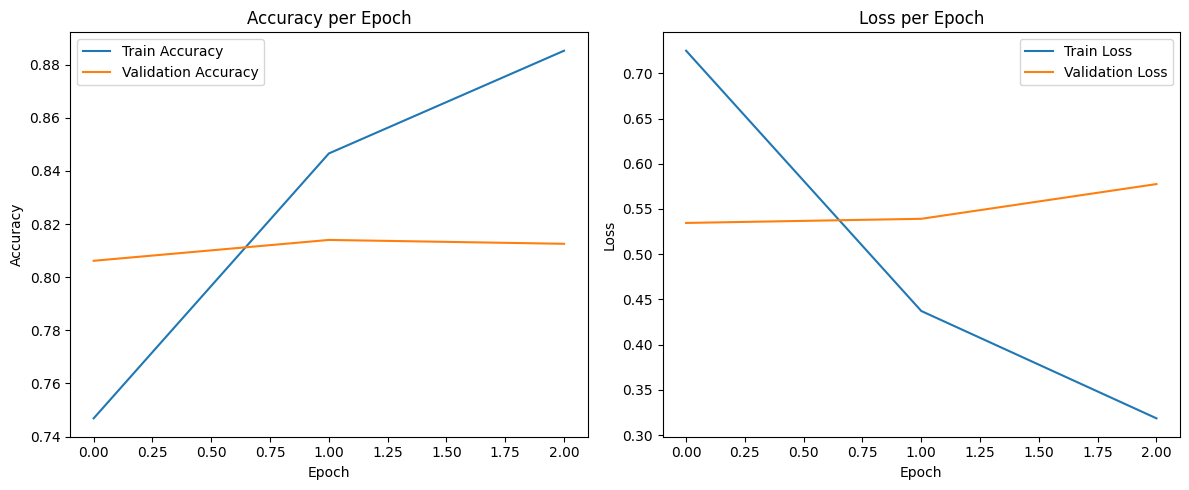

In [ ]:
# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluasi Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")

216/216 [==============================] - 21s 82ms/step - loss: 0.5736 - accuracy: 0.8260

Test Accuracy: 0.8260


216/216 [==============================] - 21s 83ms/step


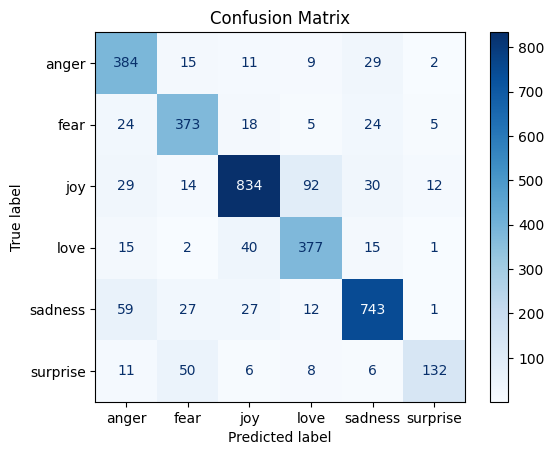

In [ ]:
# Prediksi pada data test
y_pred = model.predict(test_dataset)
y_pred_labels = tf.argmax(y_pred.logits, axis=1).numpy()

# Decode label kembali ke bentuk string
y_test_decoded = label_encoder.inverse_transform(test_labels.numpy())
y_pred_decoded = label_encoder.inverse_transform(y_pred_labels)

# Buat confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Inferensi Sederhana

In [ ]:
teks_inferensi = "mantep banget hari ini"

inputs = tokenizer(teks_inferensi, return_tensors='tf', truncation=True, padding=True)

outputs = model(inputs)
logits = outputs.logits

predicted_class_id = int(tf.math.argmax(logits, axis=-1).numpy()[0])
predicted_label = label_encoder.inverse_transform([predicted_class_id])[0]

print(f"Teks: {teks_inferensi}")
print(f"Prediksi: {predicted_label}")

Teks: mantep banget hari ini
Prediksi: joy


### Save Model

In [ ]:
# Simpan model ke folder 'saved_model'
model.save_pretrained("saved_model/",save_format="tf")
tokenizer.save_pretrained("saved_model/",save_format="tf")

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

### Testing Inference

In [ ]:
model_path = "./saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = TFAutoModelForSequenceClassification.from_pretrained(model_path, from_pt=False)

Some layers from the model checkpoint at ./saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
text = "Saya sedang merasa sangat sedih dan kecewa."
inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
outputs = model(inputs)
pred = tf.math.argmax(outputs.logits, axis=1).numpy()[0]
print("Predicted class:", pred)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted class: 4
